## Ground state approximation via VQE

In [1]:
import numpy as np

import qibo
from qibo import Circuit, gates, hamiltonians
from qibo import optimizers

from qiboedu.scripts.plotscripts import plot_vqe_states

qibo.set_backend("numpy")

[Qibo 0.2.6|INFO|2024-04-04 12:07:51]: Using numpy backend on /CPU:0


#### Problem setup: $H_{\rm target}$ and circuit $\mathcal{U}(\theta)$

In [2]:
def build_hamiltonian(nqubits, h):
    """
    Build Transverse Field Ising Model with `nqubits` and 
    transverse field `h`.
    """
    return hamiltonians.TFIM(nqubits=nqubits, h=h)

In [3]:
def build_vqe_circuit(nqubits, nlayers):
    """Build the Variational Quantum Eigensolver circuit."""
    c = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=0))
            c.add(gates.RZ(q=q, theta=0))
        for q in range(0, nqubits-1, 1):
            c.add(gates.CNOT(q0=q, q1=q+1))
        c.add(gates.CNOT(q0=nqubits-1, q1=0))
    c.add(gates.M(*range(nqubits)))
    return c

#### Loss function definition

In [4]:
def loss_function(parameters, circuit, hamiltonian):
    """
    Compute the expectation value of `hamiltonian` over the final state
    we get by executing `circuit` filled with `parameters`.
    """
    circuit.set_parameters(parameters)
    final_state = circuit().state()

    return hamiltonian.expectation(final_state)

#### Execution

In [5]:
# set number of qubits and layers (circuit architecture)
nqubits = 4
nlayers = 4

# build circuit and draw it
c = build_vqe_circuit(nqubits, nlayers)
print(c.draw())

q0: ─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─M─
q1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
q2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
q3: ─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─M─


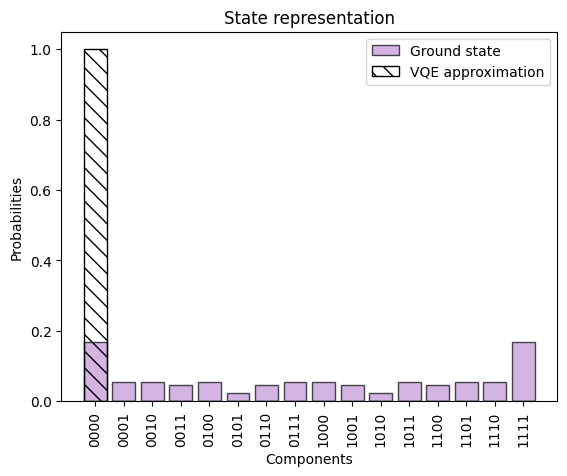

In [7]:
# build hamiltonian and collect ground state
h = build_hamiltonian(nqubits, h=2)
ground_state = h.ground_state()

# plot ground state VS VQE's state
plot_vqe_states(ground_state, c().state())

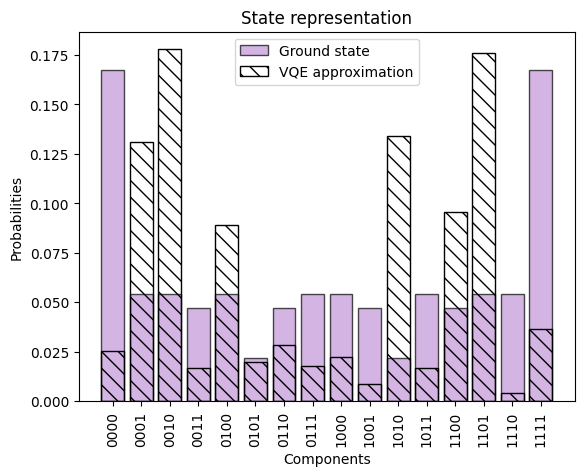

In [8]:
# set initial parameters
np.random.seed(42)
nparams = len(c.get_parameters())
initial_p = np.random.randn(nparams)

# final state after execution with random parameters
c.set_parameters(initial_p)

# plot 
plot_vqe_states(ground_state, c().state())

In [9]:
# optimize and
# collect optimization results
result = optimizers.optimize(
    loss=loss_function, 
    initial_parameters=initial_p,
    args=(c, h),
    method="Powell"
)

In [10]:
# best parameters
best_p = result[1]
print(best_p)

[-1.96615004e+00 -8.25909456e-01 -8.63022836e-01  1.56007476e+00
 -1.57575715e+00  1.34650500e-03  2.64044207e+00 -8.23427501e-02
  1.59806752e+00  1.13181850e+00  4.86563027e-01 -1.04557426e+00
  1.55978678e+00 -2.88853898e+00 -1.58029957e+00 -7.01532012e-01
 -1.46543569e-02  3.02450197e-01  1.28406152e-02 -1.25216023e+00
  1.22442077e+00  3.20441519e-01 -5.77461806e-01 -1.13645273e+00
 -1.25357736e-01  7.35585920e-01 -1.56835530e+00  1.07683767e-02
 -9.61504167e-01  2.36622045e-02  7.85078805e-02  1.89025112e+00]


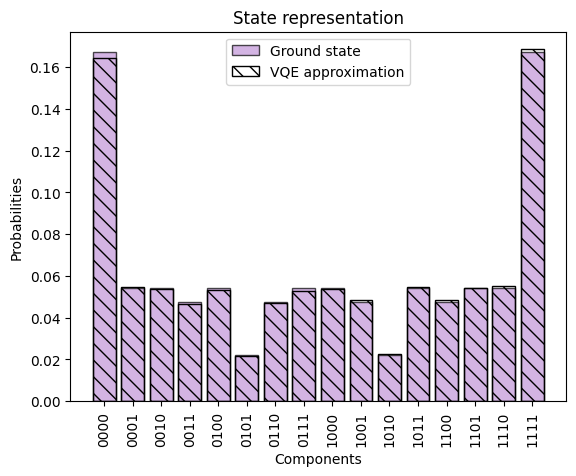

In [11]:
# set best parameters into the circuit
c.set_parameters(best_p)

# plot ground state VS VQE's state
plot_vqe_states(ground_state, c().state())